<a href="http://colab.research.google.com/github/dipanjanS/nlp_workshop_odsc19/blob/master/Module05%20-%20NLP%20Applications/Project07E%20-%20Text%20Classification%20with%20BERT%20Deep%20Transfer%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification with BERT - Deep Transfer Learning

![](https://i.imgur.com/MFd6n82.png)

# Install Dependencies

In [60]:
!pip install contractions
!pip install bert-tensorflow
!pip install tqdm
!pip install tensorflow_hub

You should consider upgrading via the '/opt/app-root/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/app-root/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/app-root/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/app-root/bin/python3.9 -m pip install --upgrade pip' command.


In [61]:
!pip install transformers

You should consider upgrading via the '/opt/app-root/bin/python3.9 -m pip install --upgrade pip' command.


# Load Dependencies

In [62]:
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow_hub as tf_hub
import time
import numpy as np
import os
from bert.tokenization import FullTokenizer
import tqdm
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# tf.logging.set_verbosity(tf.logging.INFO)
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

%matplotlib inline

# GPU Test

In [63]:
print(tf.__version__)
print(tf_hub.__version__)

2.6.0
0.12.0


In [64]:
print(tf.test.is_gpu_available())
print(tf.test.gpu_device_name())

False



In [65]:
!nvidia-smi

/usr/bin/sh: line 1: nvidia-smi: command not found


# Load and View Dataset

In [66]:
dataset1 = pd.read_csv("consumer_complaints.csv")
dataset1.info()

/opt/app-root/lib64/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (5,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date_received                 555957 non-null  object
 1   product                       555957 non-null  object
 2   sub_product                   397635 non-null  object
 3   issue                         555957 non-null  object
 4   sub_issue                     212622 non-null  object
 5   consumer_complaint_narrative  66806 non-null   object
 6   company_public_response       85124 non-null   object
 7   company                       555957 non-null  object
 8   state                         551070 non-null  object
 9   zipcode                       551452 non-null  object
 10  tags                          77959 non-null   object
 11  consumer_consent_provided     123458 non-null  object
 12  submitted_via                 555957 non-null  object
 13 

In [67]:
# dataset[['consumer_complaint_narrative','product']]
# dataset1 = pd.DataFrame(columns=['review', 'sentiment'])

In [68]:
# dataset = pd.DataFrame(columns=['review', 'sentiment'])
dataset = dataset1[['consumer_complaint_narrative','product']]
dataset.rename({'consumer_complaint_narrative': 'review', 'product': 'sentiment'}, axis=1, inplace=True)
dataset.head()

/opt/app-root/lib64/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,review,sentiment
0,NaN,Mortgage
1,NaN,Mortgage
2,NaN,Credit reporting
3,NaN,Student loan
4,NaN,Debt collection


In [69]:
dataset = dataset[pd.notnull(dataset['review'])]

In [70]:
dataset.shape
dataset = dataset.reset_index(drop=True)

In [71]:
dataset['sentiment'].nunique()

11

In [72]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(dataset['sentiment'])


LabelEncoder()

In [73]:
list(le.classes_)

['Bank account or service',
 'Consumer Loan',
 'Credit card',
 'Credit reporting',
 'Debt collection',
 'Money transfers',
 'Mortgage',
 'Other financial service',
 'Payday loan',
 'Prepaid card',
 'Student loan']

In [74]:
dataset['sentiment'] = le.transform(dataset['sentiment'])

# list(le.inverse_transform([2, 2, 1]))

In [75]:
dataset.head(5)

,review,sentiment
0,XXXX has claimed I owe them {$27.00} for XXXX ...,4
1,Due to inconsistencies in the amount owed that...,1
2,In XX/XX/XXXX my wages that I earned at my job...,6
3,I have an open and current mortgage with Chase...,6
4,XXXX was submitted XX/XX/XXXX. At the time I s...,6


In [78]:
dataset.shape[0]

66806

In [77]:
# dataset = pd.read_csv('https://github.com/dipanjanS/nlp_workshop_dhs18/raw/master/Unit%2011%20-%20Sentiment%20Analysis%20-%20Unsupervised%20Learning/movie_reviews.csv.bz2', compression='bz2')
# dataset.info()

In [ ]:
# dataset['sentiment'] = [1 if sentiment == 'positive' else 0 
#                             for sentiment in dataset['sentiment'].values]
# dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [59]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

max_length_test = 20
test_sentence = 'Test tokenization sentence. Followed by another sentence'

# add special tokens

test_sentence_with_special_tokens = '[CLS]' + test_sentence + '[SEP]'

tokenized = tokenizer.tokenize(test_sentence_with_special_tokens)

print('tokenized', tokenized)

# convert tokens to ids in WordPiece
input_ids = tokenizer.convert_tokens_to_ids(tokenized)

# precalculation of pad length, so that we can reuse it later on
padding_length = max_length_test - len(input_ids)

# map tokens to WordPiece dictionary and add pad token for those text shorter than our max length
input_ids = input_ids + ([0] * padding_length)

# attention should focus just on sequence with non padded tokens
attention_mask = [1] * len(input_ids)

# do not focus attention on padded tokens
attention_mask = attention_mask + ([0] * padding_length)

# token types, needed for example for question answering, for our purpose we will just set 0 as we have just one sequence
token_type_ids = [0] * max_length_test

bert_input = {
    "token_ids": input_ids,
    "token_type_ids": token_type_ids,
    "attention_mask": attention_mask
} 
print(bert_input)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenized ['[CLS]', 'test', 'token', '##ization', 'sentence', '.', 'followed', 'by', 'another', 'sentence', '[SEP]']
{'token_ids': [101, 3231, 19204, 3989, 6251, 1012, 2628, 2011, 2178, 6251, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


In [80]:
total_complaints = np.append(dataset['review'].values)
MAX_SEQUENCE_LENGTH = max([len(c.split()) for c in total_complaints])
MAX_SEQUENCE_LENGTH

bert_input = tokenizer.encode_plus(
                        dataset['review'].values,                      
                        add_special_tokens = True, # add [CLS], [SEP]
                        max_length = MAX_SEQUENCE_LENGTH, # max length of the text that can go to BERT
                        pad_to_max_length = True, # add [PAD] tokens
                        return_attention_mask = True, # add attention mask to not focus on pad tokens
              )

print('encoded', bert_input)

TypeError: _append_dispatcher() missing 1 required positional argument: 'values'

# Prepare Train, Validation and Test Datasets

In [43]:
train_df = dataset.iloc[:10000]
val_df = dataset.iloc[30000:35000]
test_df = dataset.iloc[35000:]

train_df.shape, val_df.shape, test_df.shape

((10000, 2), (5000, 2), (31806, 2))

In [44]:
train_text = train_df['review'].tolist()
train_labels = train_df['sentiment'].tolist()

val_text = val_df['review'].tolist()
val_labels = val_df['sentiment'].tolist()

test_text = test_df['review'].tolist()
test_labels = test_df['sentiment'].tolist()

# Minimal Text Wrangling

In [45]:
from bs4 import BeautifulSoup
import tqdm
import re

def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def clean_docs(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    norm_docs.append(doc)
  return norm_docs

train_text = clean_docs(train_text)
val_text = clean_docs(val_text)
test_text = clean_docs(test_text) 

100%|██████████| 31806/31806 [00:02<00:00, 11211.75it/s]


# BERT Data Preparation

We'll need to transform our data into a format BERT understands. This involves two steps. First, we create InputExample's based on the constructor provided in the BERT library (we model based on that).

- `text_a` is the text we want to classify, which in this case, is the review field in our Dataframe.
- `text_b` is used if we're training a model to understand the relationship between sentences (i.e. is `text_b` a translation of `text_a`? Is `text_b` an answer to the question asked by `text_a`?). This doesn't apply to our task, so we can leave `text_b` blank.
- `label` is the label for our example, i.e. 1, 0


Next, we need to preprocess our data so that it matches the data BERT was trained on. For this, we'll need to do a couple of things.

- Lowercase our text (if we're using a BERT lowercase model)
- Tokenize it (i.e. "sally says hi" -> ["sally", "says", "hi"])
- Break words into WordPieces (i.e. "calling" -> ["call", "##ing"])
- Map our words to indexes using a vocab file that BERT provides
- Add special "CLS" and "SEP" tokens (see the readme)
- Append "index" and "segment" tokens to each input (see the BERT paper)

## BERT InputExamples

In [46]:
class PaddingInputExample(object):
  pass
    
    
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

# BERT Tokenization

The BERT model we're using expects lowercase data (that's what stored in the tokenization_info parameter do_lower_case. Besides this, we also loaded BERT's vocab file. Finally, we created a tokenizer, which breaks words into word pieces.

Word Piece Tokenizer is based on [Byte Pair Encodings (BPE)](https://www.aclweb.org/anthology/P16-1162).

WordPiece and BPE are two similar and commonly used techniques to segment words into subword-level in NLP tasks. In both cases, the vocabulary is initialized with all the individual characters in the language, and then the most frequent/likely combinations of the symbols in the vocabulary are iteratively added to the vocabulary.

magine that the model sees the word walking. Unless this word occurs at least a few times in the training corpus, the model can't learn to deal with this word very well. However, it may have the words walked, walker, walks, each occurring only a few times. Without subword segmentation, all these words are treated as completely different words by the model.

However, if these get segmented as walk@@ ing, walk@@ ed, etc., notice that all of them will now have walk@@ in common, which will occur much frequently while training, and the model might be able to learn more about it.

In [47]:
def create_tokenizer_from_hub_module(bert_path):
    """Get the vocab file and casing info from the Hub module."""
    bert_module =  tf_hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

# BERT Input Feature Extractor

Follows the InputExample instance format of converting each text into:
- guid
- text_a
- text_b
- label (optional)

![](https://i.imgur.com/sY0xQih.png)



In [48]:
def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=text, text_b=None, label=label)
        )
    return InputExamples

In [49]:
def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm.tqdm(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

# Loading BERT Tokenizer

In [52]:
# Initialize session
# sess = tf.Session()

# Params for bert model and tokenization
BERT_PATH = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
MAX_SEQ_LENGTH = 512

In [53]:
# Instantiate tokenizer
tokenizer = create_tokenizer_from_hub_module(bert_path=BERT_PATH)

RuntimeError: Exporting/importing meta graphs is not supported when eager execution is enabled. No graph exists when eager execution is enabled.

# Convert Text Data to BERT Input Features

In [ ]:
# Convert data to InputExample format
train_examples = convert_text_to_examples(train_text, train_labels)
val_examples = convert_text_to_examples(val_text, val_labels)
test_examples = convert_text_to_examples(test_text, test_labels)

In [ ]:
(train_input_ids, train_input_masks, 
 train_segment_ids, train_labels) =  convert_examples_to_features(tokenizer=tokenizer, 
                                                                  examples=train_examples, 
                                                                  max_seq_length=MAX_SEQ_LENGTH)

(val_input_ids, val_input_masks, 
 val_segment_ids, val_labels) =  convert_examples_to_features(tokenizer=tokenizer, 
                                                              examples=val_examples, 
                                                              max_seq_length=MAX_SEQ_LENGTH)

(test_input_ids, test_input_masks, 
 test_segment_ids, test_labels) =  convert_examples_to_features(tokenizer=tokenizer, 
                                                                examples=test_examples, 
                                                                max_seq_length=MAX_SEQ_LENGTH)

In [ ]:
train_input_ids.shape, val_input_ids.shape, test_input_ids.shape

# Load BERT Model

![](https://i.imgur.com/84Din4P.png)

In [54]:
bm = tf_hub.Module(BERT_PATH, trainable=True, name=f"bert_module")
bm

RuntimeError: Exporting/importing meta graphs is not supported when eager execution is enabled. No graph exists when eager execution is enabled.

In [55]:
len(bm.variables)

NameError: name 'bm' is not defined

# Custom BERT Layer to fine-tune BERT Encoder Layers

![](https://i.imgur.com/gnIxACX.png)

In [ ]:
class BertLayer(tf.keras.layers.Layer):
    
    def __init__(self, bert_path, n_fine_tune_encoders=10, **kwargs,):
        
        self.n_fine_tune_encoders = n_fine_tune_encoders
        self.trainable = True
        self.output_size = 768
        self.bert_path = bert_path
        super(BertLayer, self).__init__(**kwargs)

        
    def build(self, input_shape):
        self.bert = tf_hub.Module(self.bert_path,
                                  trainable=self.trainable, 
                                  name=f"{self.name}_module")

        # Remove unused layers
        trainable_vars = self.bert.variables
        trainable_vars = [var for var in trainable_vars 
                                  if not "/cls/" in var.name]
        trainable_layers = ["embeddings", "pooler/dense"]


        # Select how many layers to fine tune
        for i in range(self.n_fine_tune_encoders+1):
            trainable_layers.append(f"encoder/layer_{str(10 - i)}")

        # Update trainable vars to contain only the specified layers
        trainable_vars = [var for var in trainable_vars
                                  if any([l in var.name 
                                              for l in trainable_layers])]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert.variables:
            if var not in self._trainable_weights:# and 'encoder/layer' not in var.name:
                self._non_trainable_weights.append(var)
        print('Trainable layers:', len(self._trainable_weights))
        print('Non Trainable layers:', len(self._non_trainable_weights))

        super(BertLayer, self).build(input_shape)

        
    def call(self, inputs):
        
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(input_ids=input_ids, 
                           input_mask=input_mask, 
                           segment_ids=segment_ids)
        
        pooled = self.bert(inputs=bert_inputs, 
                           signature="tokens", 
                           as_dict=True)["pooled_output"]

        return pooled

    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size) 

# Integrate BERT Model for Downstream Classification Task

In [ ]:
# Build model
def build_model(bert_path, max_seq_length, n_fine_tune_encoders=10): 
    
    inp_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
    inp_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
    inp_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
    bert_inputs = [inp_id, inp_mask, inp_segment]
    
    bert_output = BertLayer(bert_path=bert_path, 
                            n_fine_tune_encoders=n_fine_tune_encoders)(bert_inputs)
    
    dense = tf.keras.layers.Dense(256, activation='relu')(bert_output)
    pred = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss='binary_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(lr=2e-5), 
                  metrics=['accuracy'])    
    return model

# Build BERT Classifier Model Architecture

In [ ]:
def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [ ]:
MAX_SEQ_LENGTH

512

In [ ]:
model = build_model(bert_path=BERT_PATH, max_seq_length=MAX_SEQ_LENGTH, n_fine_tune_encoders=10)

# Instantiate variables
initialize_vars(sess)

Trainable layers: 199
Non Trainable layers: 5


I0806 05:50:59.351067 140647828572032 saver.py:1499] Saver not created because there are no variables in the graph to restore
W0806 05:51:05.398488 140647828572032 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0806 05:51:05.472497 140647828572032 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
bert_layer (BertLayer)          (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]            

# Train BERT Classifier (fine-tune)

In [ ]:
model.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([val_input_ids, val_input_masks, val_segment_ids], val_labels),
    epochs=2,
    batch_size=15,
    verbose=1
)

Train on 5000 samples, validate on 5000 samples
Epoch 1/2
5000/5000 [==============================] - 819s 164ms/sample - loss: 0.3019 - acc: 0.8696 - val_loss: 0.2122 - val_acc: 0.9136
Epoch 2/2
5000/5000 [==============================] - 812s 162ms/sample - loss: 0.1035 - acc: 0.9650 - val_loss: 0.2317 - val_acc: 0.9188


# Evaluate Model Performance

In [ ]:
test_predictions = model.predict(x=[test_input_ids, 
                                    test_input_masks, 
                                    test_segment_ids],
                                 batch_size=100,
                                 verbose=1)

15000/15000 [==============================] - 661s 44ms/sample


In [ ]:
test_predictions = test_predictions.ravel()

In [ ]:
test_pred_labels = [1 if prob > 0.5 else 0 for prob in test_predictions]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print('Classification Report:')
print(classification_report(y_true=test_labels, y_pred=test_pred_labels))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      7490
           1       0.92      0.92      0.92      7510

    accuracy                           0.92     15000
   macro avg       0.92      0.92      0.92     15000
weighted avg       0.92      0.92      0.92     15000



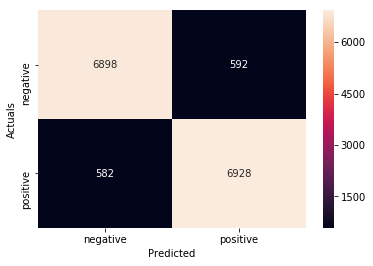

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

with tf.Session() as session:
    cm = tf.confusion_matrix(test_labels, test_pred_labels).eval()

LABELS = ['negative', 'positive']
sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS, fmt='g')
xl = plt.xlabel("Predicted")
yl = plt.ylabel("Actuals")

# Take Home - Train and fine-tune BERT on the full training data

Here we did see BERT's power by training the model on only 5000 examples. But you can bump up the performance even more by using the full training data.

For reference, use [this notebook](https://github.com/fabric8-analytics/openshift-probable-vulnerabilities/blob/master/notebooks/modeling/deep_learning_models/phase2_transformer_models/bert_sentiment_analysis_benchmark_models/BERT%20-%20TF%20Keras%20implementation%20-%20Sentiment%20Analysis-Preprocessed%20Text-Seq512.ipynb)